# Hourly Train Data Analysis(LSTM - Multiple Series)

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

## Preprocessing

In [92]:
df = pd.read_csv('./data/hourly-train.csv', header=None).values.squeeze()
df = df[1:, 1:].astype(np.float32)
df

array([[ 605.,  586.,  586., ...,   nan,   nan,   nan],
       [3124., 2990., 2862., ...,   nan,   nan,   nan],
       [1828., 1806., 1897., ...,   nan,   nan,   nan],
       ...,
       [  19.,   30.,   12., ...,   73.,   39.,   36.],
       [  21.,   16.,   17., ...,   53.,   38.,   46.],
       [  15.,   13.,   13., ...,   35.,   26.,   17.]], dtype=float32)

In [93]:
df = df.T
df

array([[ 605., 3124., 1828., ...,   19.,   21.,   15.],
       [ 586., 2990., 1806., ...,   30.,   16.,   13.],
       [ 586., 2862., 1897., ...,   12.,   17.,   13.],
       ...,
       [  nan,   nan,   nan, ...,   73.,   53.,   35.],
       [  nan,   nan,   nan, ...,   39.,   38.,   26.],
       [  nan,   nan,   nan, ...,   36.,   46.,   17.]], dtype=float32)

In [94]:
# Remove all na rows
na_rows = np.isnan(df).any(axis=1)
np.where(na_rows)
df = df[~na_rows]
print(f'shape: {df.shape}')
na_rows = np.isnan(df).any(axis=1)
print(f'na rows: {np.where(na_rows)}')

shape: (700, 414)
na rows: (array([], dtype=int64),)


In [95]:
# add dummy time and make darts time series
df = pd.DataFrame(df)
start_date = pd.Timestamp('2000-01-01 00:00:00')
series = TimeSeries.from_times_and_values(
    pd.date_range(start=start_date, periods=len(df), freq='H'),
    df.values,
)
series

/var/folders/zr/55ct9rx16hb8nk7z_w9q07900000gn/T/ipykernel_25992/1551886313.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(start=start_date, periods=len(df), freq='H'),


<TimeSeries (DataArray) (time: 700, component: 414, sample: 1)> Size: 1MB
array([[[ 605.],
        [3124.],
        [1828.],
        ...,
        [  19.],
        [  21.],
        [  15.]],

       [[ 586.],
        [2990.],
        [1806.],
        ...,
        [  30.],
        [  16.],
        [  13.]],

       [[ 586.],
        [2862.],
        [1897.],
        ...,
...
        ...,
        [  18.],
        [  17.],
        [  13.]],

       [[ 739.],
        [3248.],
        [1570.],
        ...,
        [  13.],
        [  16.],
        [  17.]],

       [[ 684.],
        [3105.],
        [1518.],
        ...,
        [  17.],
        [  15.],
        [  21.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-30T03:00:00
  * component  (component) <U3 5kB '0' '1' '2' '3' ... '410' '411' '412' '413'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## EDA(Explanatory Data Analysis)

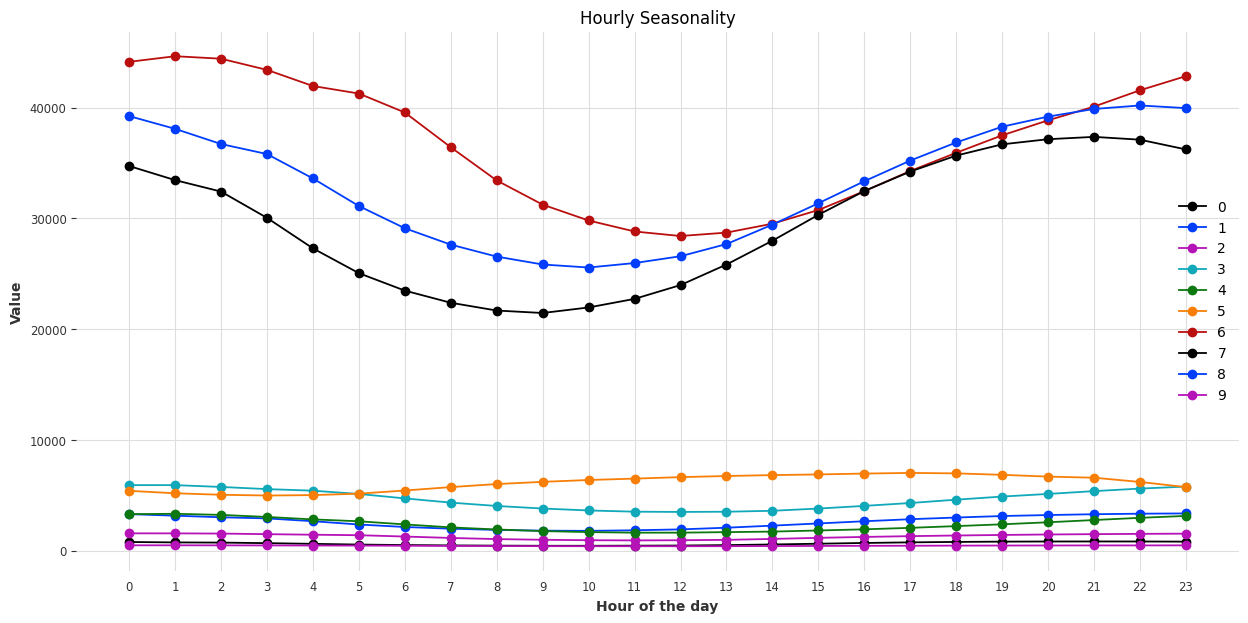

In [96]:
df_with_time = series.pd_dataframe()
hourly_means = df_with_time.groupby(df_with_time.index.hour).mean()
plt.figure(figsize=(15, 7))
plt.plot(hourly_means.iloc[:,0:10], marker='o')
plt.title('Hourly Seasonality')
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.legend(hourly_means.columns)
plt.xticks(hourly_means.index)
plt.show()

Number of components is larger than 10 (414). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


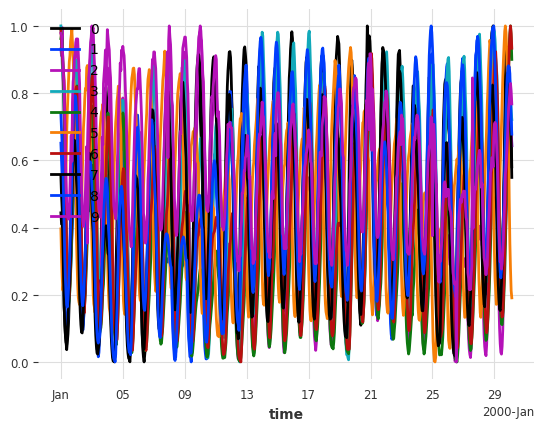

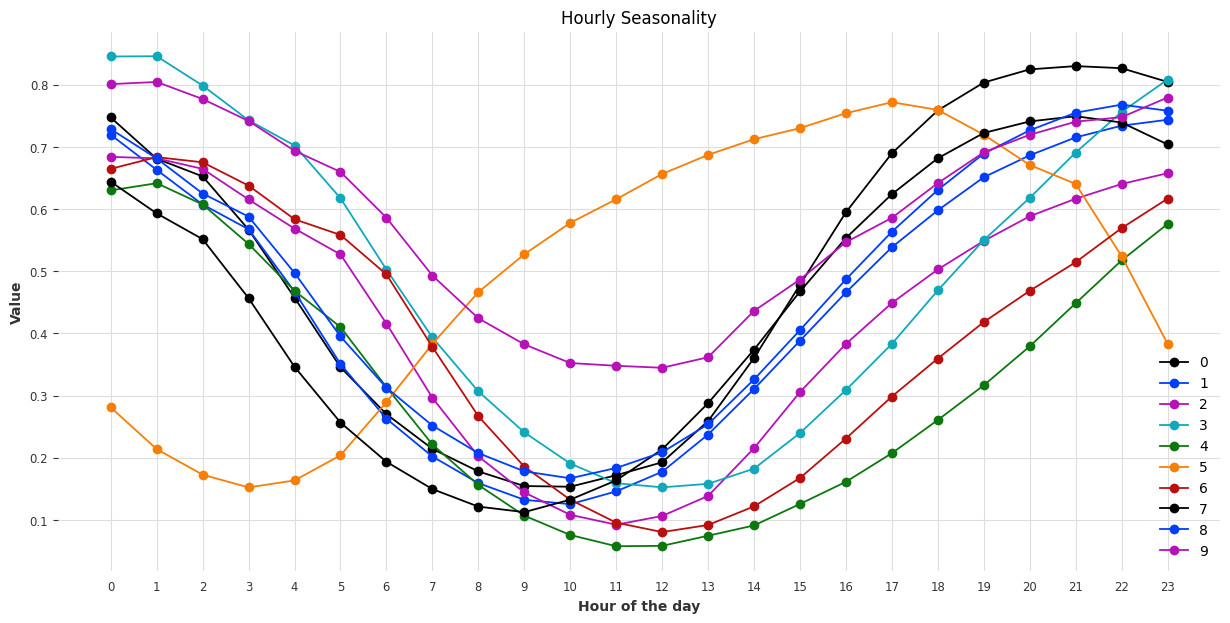

In [97]:
# Scale the data
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_scaled.plot()
df_with_time = series_scaled.pd_dataframe()

# Hourly seasonality
hourly_means = df_with_time.groupby(df_with_time.index.hour).mean()
plt.figure(figsize=(15, 7))
plt.plot(hourly_means.iloc[:,0:10], marker='o')
plt.title('Hourly Seasonality')
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.legend(hourly_means.columns)
plt.xticks(hourly_means.index)
plt.show()

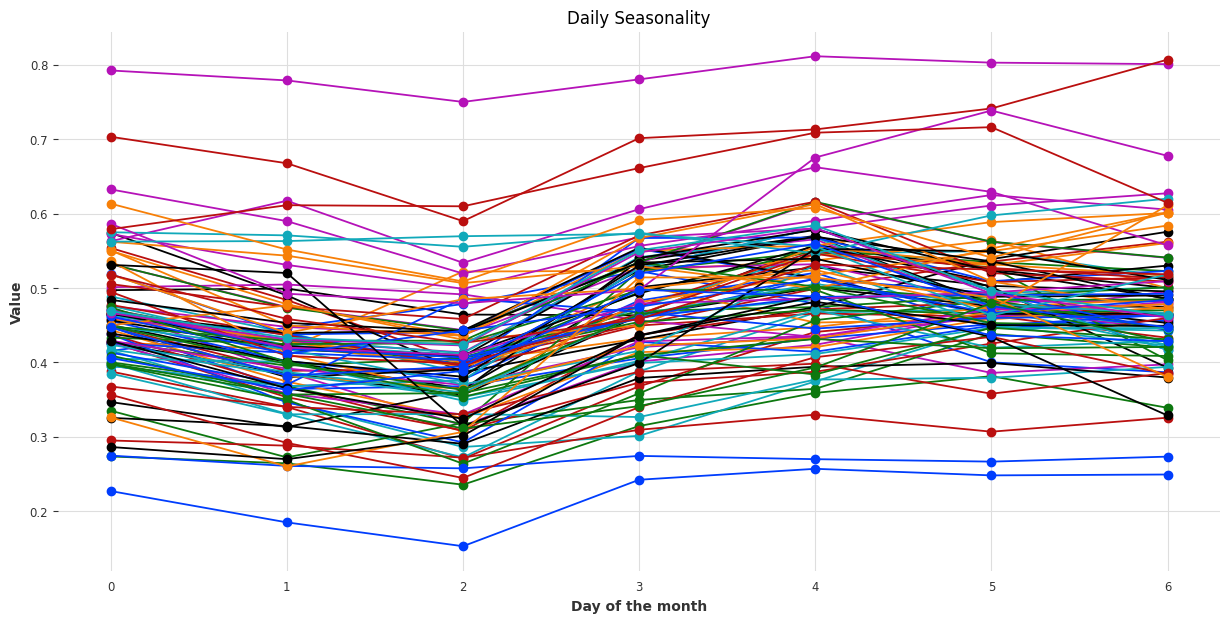

In [98]:
# Daily Seasonality

daily_means = df_with_time.groupby(df_with_time.index.dayofweek).mean()
plt.figure(figsize=(15, 7))
plt.plot(daily_means.iloc[:,0:100], marker='o')
plt.title('Daily Seasonality')
plt.xlabel('Day of the month')
plt.ylabel('Value')
plt.xticks(daily_means.index)
plt.show()

## Prepare LSTM model

In [176]:
# Make Covariates
hour_series = datetime_attribute_timeseries(series_scaled, attribute='hour', one_hot=True)
day_series = datetime_attribute_timeseries(series_scaled, attribute='weekday', one_hot=True)
covariates = day_series.stack(hour_series)
# covariates = hour_series.stack(day_series)

series_scaled = series_scaled.astype(np.float32)
covariates = covariates.astype(np.float32)

In [140]:
forecast_horizon = 48
input_chunk_length = 72
training_length = forecast_horizon + input_chunk_length

In [ ]:
model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.1,
    n_epochs=20,
    optimizer_kwargs={'lr': 0.003},
    random_state=42,
    input_chunk_length=input_chunk_length,
    training_length=training_length,
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        "devices": -1
    },
)

model.fit(
    series_scaled,
    future_covariates=covariates
)

## Cross Validation

In [ ]:
cv = model.historical_forecasts(
    series=series_scaled,
    future_covariates=covariates,
    start=df.shape[0] - 200,
    forecast_horizon=forecast_horizon,
    stride=24,
    retrain=True,
    last_points_only=False,
)

In [206]:
rmse_list = []
for i in range(len(cv)):
    predictions = TimeSeries.pd_dataframe(scaler.inverse_transform(cv[i]))
    actuals = TimeSeries.pd_dataframe(series[predictions.index.min(): predictions.index.max()])
    # rmse = root_mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_list.append(rmse)
print(f'RMSE: {np.mean(rmse_list)}')

RMSE: 5709.566549599859


Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger t

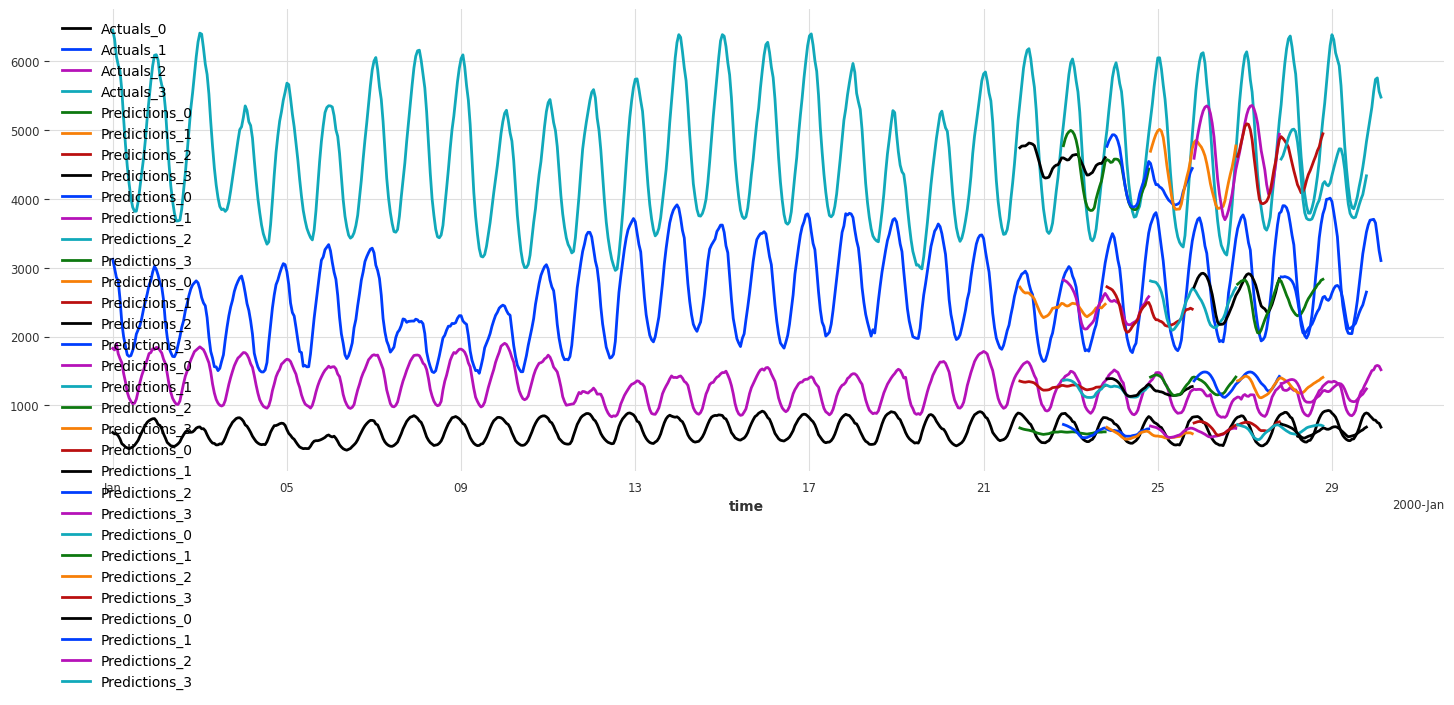

In [207]:
plt.figure(figsize=(18, 6))
series.plot(label='Actuals', max_nr_components=4)
plt.xlabel('Time')
plt.ylabel('Value')
for i in range(len(cv)):
    predictions = scaler.inverse_transform(cv[i])
    predictions.plot(label='Predictions', max_nr_components=4)
    
plt.legend()
plt.show()

## Tuning Parameters

In [208]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [2,4],
              'hidden_dim': [10,20],
              'dropout': [0.1, 0.2],
              'n_epochs': [10, 20],
              'lr': [0.003],
              'training_length': [120],
              'input_chunk_length': [72]}

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)
# Get the total number of parameter combinations
len(list(grid))

16

In [ ]:
def train_model(params):
    """
    Train the model with the given parameters and return the RMSE.
    """
    # Unpack the parameters
    n_rnn_layers = params['n_rnn_layers']
    hidden_dim = params['hidden_dim']
    dropout = params['dropout']
    n_epochs = params['n_epochs']
    lr = params['lr']
    training_length = params['training_length']
    input_chunk_length = params['input_chunk_length']

    # Create and train the model
    model = RNNModel(
        model='LSTM',
        input_chunk_length=input_chunk_length,
        n_epochs=n_epochs,
        dropout=dropout,
        training_length=training_length,
        optimizer_kwargs={'lr': lr},
        random_state=42,
        n_rnn_layers=n_rnn_layers,
        hidden_dim=hidden_dim,
        pl_trainer_kwargs={
            'accelerator': 'gpu',
            "devices": -1
        },
    )

    model.fit(series_scaled, future_covariates=covariates, verbose=True)

    # Perform cross-validation
    cv = model.historical_forecasts(
        series=series_scaled,
        future_covariates=covariates,
        start=df.shape[0] - 200,
        forecast_horizon=forecast_horizon,
        stride=24,
        retrain=True,
        last_points_only=False,
        verbose=False
    )

    # Calculate RMSE for each forecast
    rmse_list = []
    for i in range(len(cv)):
        predictions = TimeSeries.pd_dataframe(scaler.inverse_transform(cv[i]))
        actuals = TimeSeries.pd_dataframe(series[predictions.index.min(): predictions.index.max()])
        rmse = root_mean_squared_error(actuals, predictions)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

best_rmse = float('inf')
best_params = None
rmse_list = []

# Iterate through all parameter combinations
for params in grid:
    print(f"Testing parameters: {params}")
    rmse = train_model(params)
    print(f"RMSE: {rmse}")
    rmse_list.append(rmse)

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

In [211]:
outcome = pd.DataFrame(list(grid))
outcome['Mean RMSE'] = rmse_list
outcome

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,Mean RMSE
0,0.1,10,72,0.003,10,2,120,1305.574685
1,0.1,10,72,0.003,10,4,120,1577.306875
2,0.1,10,72,0.003,20,2,120,1429.732051
3,0.1,10,72,0.003,20,4,120,1621.072557
4,0.1,20,72,0.003,10,2,120,1511.584731
5,0.1,20,72,0.003,10,4,120,1647.285644
6,0.1,20,72,0.003,20,2,120,1125.840637
7,0.1,20,72,0.003,20,4,120,1434.822333
8,0.2,10,72,0.003,10,2,120,1198.904478
9,0.2,10,72,0.003,10,4,120,1505.993704


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 40.7 K | train
6 | V               | Linear           | 8.7 K  | train
-------------------------------------------------------------
49.4 K    Trainable params
0         Non-trainable params
49.4 K    Total params
0.198     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause perf

RMSE: 5709.566549599859


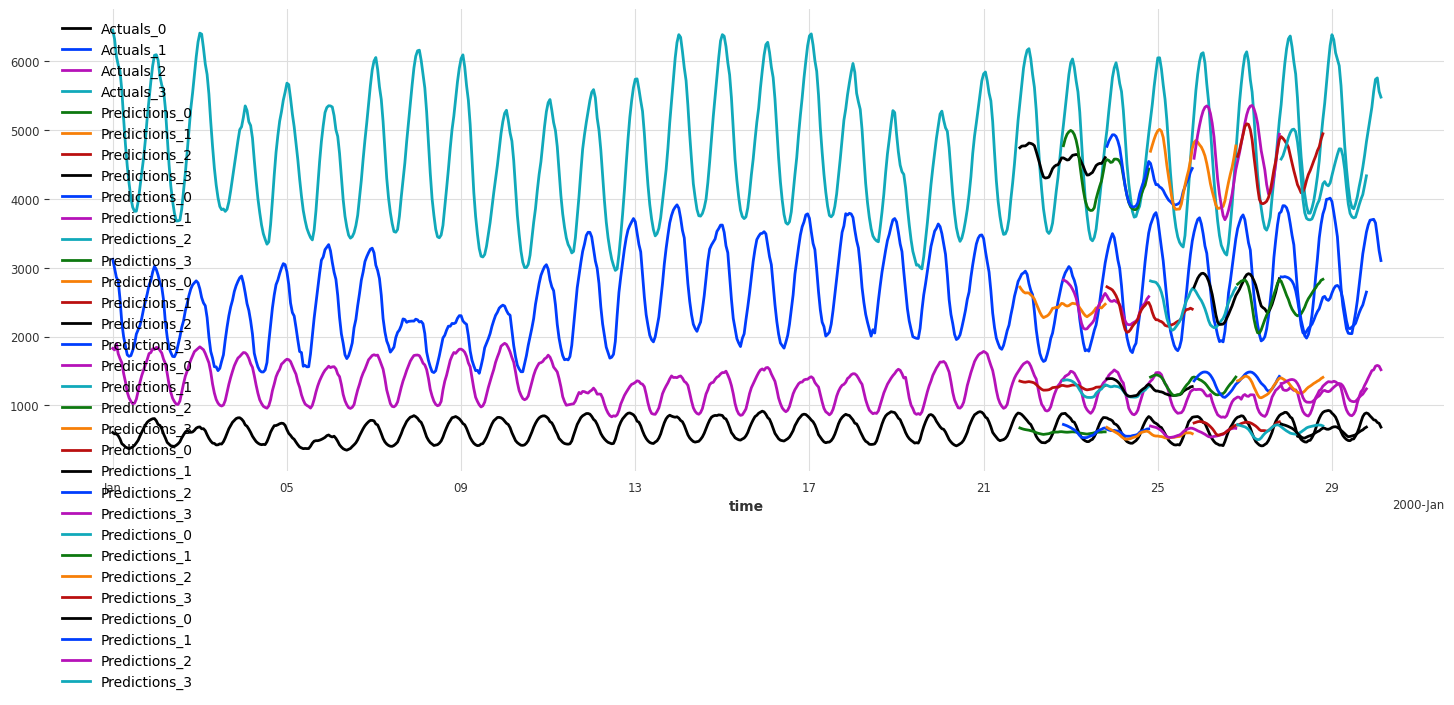

In [214]:
model = RNNModel(
    model='LSTM',
    input_chunk_length=best_params['input_chunk_length'],
    n_epochs=best_params['n_epochs'],
    dropout=best_params['dropout'],
    training_length=best_params['training_length'],
    optimizer_kwargs={'lr': best_params['lr']},
    random_state=42,
    n_rnn_layers=best_params['n_rnn_layers'],
    hidden_dim=best_params['hidden_dim'],
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        "devices": -1
    },
)
model.fit(series_scaled, future_covariates=covariates, verbose=True)
rmse_list = []
for i in range(len(cv)):
    predictions = TimeSeries.pd_dataframe(scaler.inverse_transform(cv[i]))
    actuals = TimeSeries.pd_dataframe(series[predictions.index.min(): predictions.index.max()])
    # rmse = root_mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_list.append(rmse)
print(f'RMSE: {np.mean(rmse_list)}')
plt.figure(figsize=(18, 6))
series.plot(label='Actuals', max_nr_components=4)
plt.xlabel('Time')
plt.ylabel('Value')
for i in range(len(cv)):
    predictions = scaler.inverse_transform(cv[i])
    predictions.plot(label='Predictions', max_nr_components=4)
    
plt.legend()
plt.show()

## Prediction

In [218]:
future_time_index = pd.date_range(start=series.end_time() + pd.Timedelta(hours = 1), periods=forecast_horizon, freq='H')
hour_series = datetime_attribute_timeseries(future_time_index, attribute='hour', one_hot=True)
day_series = datetime_attribute_timeseries(future_time_index, attribute='weekday', one_hot=True)
covariates_future = day_series.stack(hour_series)
covariates_future = covariates_future.astype(np.float32)
covariates = covariates.append(covariates_future)
covariates = covariates.astype(np.float32)

/var/folders/zr/55ct9rx16hb8nk7z_w9q07900000gn/T/ipykernel_25992/2631344540.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_time_index = pd.date_range(start=series.end_time() + pd.Timedelta(hours = 1), periods=forecast_horizon, freq='H')


In [ ]:
model =  RNNModel(
    model='LSTM',
    input_chunk_length=best_params['input_chunk_length'],
    n_epochs=best_params['n_epochs'],
    dropout=best_params['dropout'],
    training_length=best_params['training_length'],
    optimizer_kwargs={'lr': best_params['lr']},
    random_state=42,
    n_rnn_layers=best_params['n_rnn_layers'],
    hidden_dim=best_params['hidden_dim'],
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        "devices": -1
    },
)
model.fit(series_scaled, future_covariates=covariates)

In [ ]:
cv = model.historical_forecasts(
        series=series_scaled,
        future_covariates=covariates,
        start=df.shape[0] - 200,
        forecast_horizon=forecast_horizon,
        stride=24,
        retrain=True,
        last_points_only=False
    )

In [228]:
predictions = model.predict(n = forecast_horizon, future_covariates = covariates)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 4 (414). Plotting only the first 4 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger t

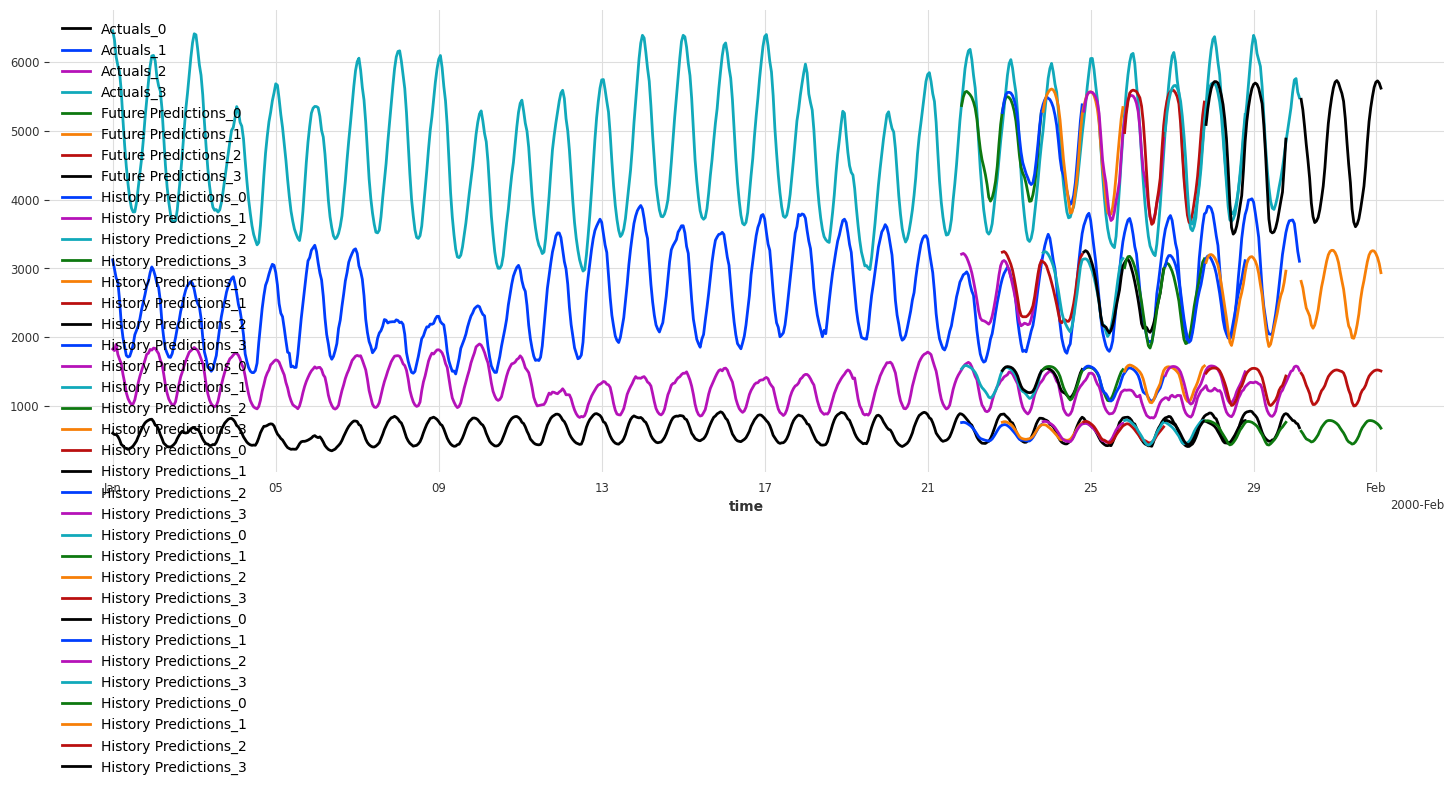

In [229]:
plt.figure(figsize=(18, 6))
series.plot(label='Actuals', max_nr_components=4)
plt.xlabel('Time')
plt.ylabel('Value')
scaler.inverse_transform(predictions).plot(label='Future Predictions', max_nr_components=4)
for i in range(len(cv)):
    his_pred = scaler.inverse_transform(cv[i])
    his_pred.plot(label='History Predictions', max_nr_components=4)


    
plt.legend()
plt.show()